In [65]:
import decode_eeg
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pandas as pd

np.random.seed(42)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
output_dir = Path('./output')
fig_dir = output_dir / 'figures' / 'behavior'

experiment_names = ['1801','1901','1902']
for iexp,experiment_name in enumerate(experiment_names):
    
    data_dir = f'./data/{experiment_name}'
    exp = decode_eeg.Experiment(experiment_name,data_dir,test=False)
    
    for isub in range(exp.nsub):
        # Load subject's behavior data
        behavior = pd.DataFrame(exp.load_behavior(isub))
        if (iexp == 0) & (isub == 0):
            ss_mean = behavior.groupby(['SetSize'])['ACC'].mean()
        else:
            ss_mean = np.concatenate([ss_mean,behavior.groupby(['SetSize'])['ACC'].mean(0)])
    
    if iexp == 0:
        subs = np.repeat(range(exp.nsub),4)
        exps = np.repeat(iexp,exp.nsub*4)
        ss = np.tile([1,2,3,4],exp.nsub)
    else:
        subs = np.concatenate([subs,np.repeat(range(exp.nsub),4)])
        exps = np.concatenate([exps,np.repeat(iexp,exp.nsub*4)])
        ss = np.concatenate([ss,np.tile([1,2,3,4],exp.nsub)])

In [67]:
df = pd.DataFrame({'Experiment':exps,'Subject':subs, 'Set size': ss, 'Accuracy': ss_mean})

In [68]:
total_means = df.groupby(['Experiment','Set size'])['Accuracy'].mean()
total_means

Experiment  Set size
0           1           0.915006
            2           0.884890
            3           0.831904
            4           0.756553
1           1           0.964356
            2           0.915661
            3           0.831542
            4           0.755915
2           1           0.965957
            2           0.902765
            3           0.800773
            4           0.722885
Name: Accuracy, dtype: float64

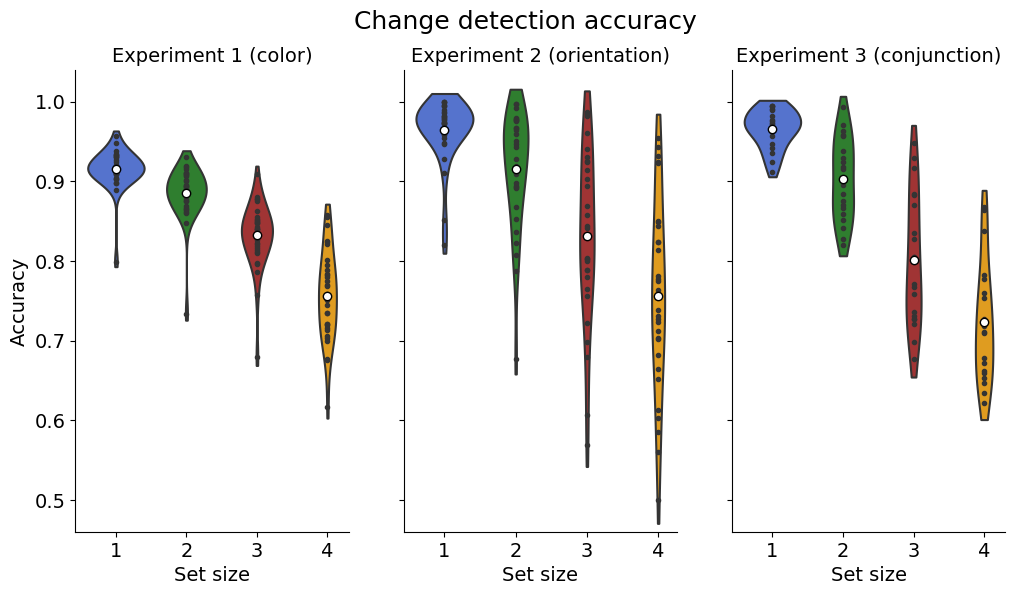

In [69]:
fig, axes = plt.subplots(1, 3, sharey=True, figsize=(12,6))
fig.suptitle('Change detection accuracy',fontsize=18)
my_pal = {"royalblue", "firebrick", "forestgreen", "orange"}

# experiment 1
sns.violinplot(
    ax = axes[0], 
    x='Set size',y='Accuracy', 
    data=df[df['Experiment']==0],
    dodge=True,inner='points',cut=.5,palette = my_pal)

axes[0].set_title('Experiment 1 (color)',fontsize=14)

# experiment 2
sns.violinplot(
    ax = axes[1], 
    x='Set size',y='Accuracy', 
    data=df[df['Experiment']==1],
    dodge=True,inner='points',cut=.5,palette = my_pal) 

axes[1].set_title('Experiment 2 (orientation)',fontsize=14)

# experiment 3
sns.violinplot(
    ax = axes[2], 
    x='Set size',y='Accuracy', 
    data=df[df['Experiment']==2],
    dodge=True,inner='points',cut=.5,palette = my_pal) 

axes[2].set_title('Experiment 3 (conjunction)',fontsize=14)

for iax,ax in enumerate(axes):

    # plot means
    ax.scatter(
        x = [0,1,2,3],
        y = [total_means[iax][1],total_means[iax][2],total_means[iax][3],total_means[iax][4]],
        c = 'white', edgecolors='k')

    # asethetics
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.setp(ax.get_xticklabels(), fontsize=14)
    plt.setp(ax.get_yticklabels(), fontsize=14)
    ax.set_xlabel('Set size',fontsize=14)
    if iax == 0:
        ax.set_ylabel('Accuracy',fontsize=14)
    else:
        ax.set_ylabel('')
plt.ylim([.46,1.04])
plt.savefig('output/figures/cd_accuracy.png',dpi=500)
plt.savefig('output/figures/cd_accuracy.pdf',dpi=500)
plt.show()

# K 

In [38]:
# Functions for calculating K from behavior
def calc_outcome(row):
    """
    calculate outcome of trial 
        hit: notice a change
        miss: fail to notice a change
        rej: notice there is no change
        fa (false alarm): notice change when there isn't one
    """
    accuracy = row['ACC']
    change = row['TrialType']
    if change == 1:
        if accuracy == 1:
            trial_outcome = 'hit'
        else:
            trial_outcome = 'miss'

    if change == 0:
        if accuracy == 1:
            trial_outcome = 'rej'
        else: 
            trial_outcome = 'fa'
    return trial_outcome

def _calc_k(outcome, change):
    """
    a simple function that returns K.
    """
    
    hits = sum(outcome == 'hit')
    fa = sum(outcome == 'fa')

    num_change = sum(change==1)
    num_no_change = sum(change==0)

    h = hits/num_change
    f = fa/num_no_change
    k = 4*(h-f)
    return k

def calc_k(beh,ss):
    """
    Runs previous functions and returns subject K.
    """
    beh = beh[beh['SetSize']==ss]
    beh['outcome']=beh.apply(lambda row : calc_outcome(row), axis = 1)
    k = _calc_k(beh['outcome'],beh['TrialType'])
    return k

In [57]:
%%capture
experiment_names = ['1801','1901','1902']
k = []
exps = []
ss = []
for iexp,experiment_name in enumerate(experiment_names):
    
    data_dir = f'./data/{experiment_name}'
    exp = decode_eeg.Experiment(experiment_name,data_dir,test=False)
    
    for isub in range(exp.nsub):
        # Load subject's behavior data
        behavior = pd.DataFrame(exp.load_behavior(isub))
        k.append(calc_k(behavior,3))
        k.append(calc_k(behavior,4))
    exps.append(np.repeat(iexp,exp.nsub*2))
    ss.append(np.tile([3,4],exp.nsub))

In [59]:
len(k)

168

In [61]:
df = pd.DataFrame({'exp':np.concatenate(exps),'k':k,'ss':np.concatenate(ss)})

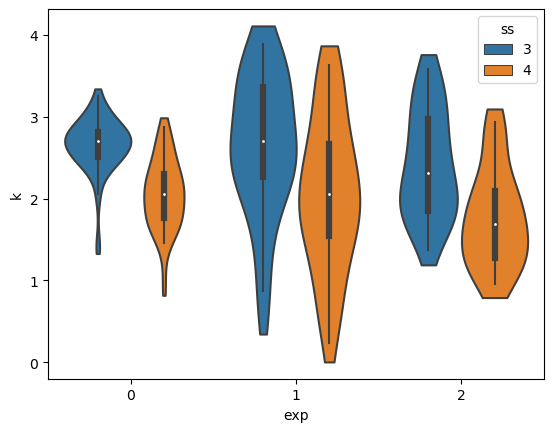

In [64]:
# experiment 1
sns.violinplot(
    x='exp',y='k', hue = 'ss',
    data=df,
    dodge=True,cut=.5)
plt.show()